<div class="row">
  <div class="column">
    <img src="./img/logo-onera.png" width="200">
  </div>
  <div class="column">
    <img src="./img/logo-ISAE_SUPAERO.png" width="200">
  </div>
</div>

# Pure python implementation

## Model implementation

We chose to represent every basic model presented in the [precedent notebook](01_summary.ipynb) as a function that will be written in a separate file. We will then assemble those models to produce a main function that will take a "guesstimate" of the **MTOW** and return the actual **MTOW** obtained using these inputs. 

We will then be able to implement a simple solving algorithm to find the **MTOW** for which the initial guess is equal to the output, meaning we solved our problem. 

To keep things even across all modules, we will have one "main" function per module that will call its sub-functions. In some cases, the main function will just be a redundancy of the sub-function, for instance, the geometry module. All main functions and sub-functions are stored in the modules folder (modules/pure_python).

The module dependency will look like:

<div class="row">
  <div class="column">
    <img src="./img/module_architecture.png" width="600">
  </div>
</div>

The module main and sub-functions can be found inside the folders named after the aircraft design disciplines they are linked to.

The **geometry** folder (modules/pure_python/geometry) contains:
* [The wing area computation](modules/pure_python/geometry/sub_components/compute_wing_area.py)

The **aerodynamics** folder (modules/pure_python/aerodynamics) contains:
* [The profile drag computation](modules/pure_python/aerodynamics/sub_components/compute_profile_drag.py)
* [The induced drag coefficient computation](modules/pure_python/aerodynamics/sub_components/compute_induced_drag_coefficient.py)
* [The cruise lift-to-drag ratio computation](modules/pure_python/aerodynamics/sub_components/compute_lift_to_drag_ratio.py)

The **mass** folder (modules/pure_python/mass) contains
* [The wing mass computation](modules/pure_python/mass/sub_components/compute_wing_mass.py)
* [The OWE computation](modules/pure_python/mass/sub_components/compute_owe.py)

The **performance** folder (modules/pure_python/performance) contains:
* [The mission fuel computation](modules/pure_python/performance/sub_components/compute_fuel_mass.py)

The **update_mtow folder** (modules/pure_python/update_mtow) contains:
* [The MTOW computation](modules/pure_python/update_mtow/update_mtow.py)

[The main file](modules/pure_python/mtow_loop.py) contains the main function that encapsulates all the functions and computes the updated **MTOW** based on the former **MTOW**.

The files in the mass model will be shown to the reader to illustrate that only very basic features are used in this example. Should the need arises, all files are accessible with the links above.

First, the wing mass computation:

> ``` python
>import scipy.constants as sc
>
>
>def compute_wing_mass(mtow, aspect_ratio, wing_area):
>    """
>    Computes the wing mass based on the MTOW, its area and aspect ratio
>
>    :param wing_area: Wing area, in m2
>    :param aspect_ratio: Wing aspect ratio, no unit
>    :param mtow: Max Take-Off Weight, in kg
>
>    :return wing mass: the wing_mass, in kg
>    """
>
>    # Let's start by converting the quantities in imperial units
>    mtow_lbm = mtow / sc.lb
>    wing_area_ft2 = wing_area / sc.foot ** 2.0
>
>    # Let's now apply the formula
>    wing_mass_lbm = (
>        96.948
>        * (
>            (5.7 * mtow_lbm / 1.0e5) ** 0.65
>            * aspect_ratio ** 0.57
>            * (wing_area_ft2 / 100.0) ** 0.61
>            * 2.5
>        )
>        ** 0.993
>    )
>
>    # Converting wing mass in kg
>    wing_mass = wing_mass_lbm * sc.lb
>
>    return wing_mass
> ```

Now, the **OWE** computation:

> ``` python
>import numpy as np
>
>
>def compute_owe(wing_mass, mtow):
>    """
>    Computes the wing mass based on the MTOW, its area and aspect ratio
>
>    :param wing_mass: Wing mass, in kg
>    :param mtow: Max Take-Off Weight, in kg
>
>    :return owe: the structural mass, in kg
>    """
>
>    # Let's start by computing the weight of the aircraft without the wings
>    owe_without_wing = mtow * (0.43 * 0.0066 * np.log(mtow))
>
>    # Let's now add the wing mass to get the structural weight
>    owe = owe_without_wing + wing_mass
>
>    return owe
> ```

And finally the mass main function :

> ``` python
>from .sub_components.compute_wing_mass import compute_wing_mass
>from .sub_components.compute_owe import compute_owe
>
>
>def compute_mass(mtow, wing_area, aspect_ratio):
>    """
>    Gather all the mass sub-functions in the main function
>
>    :param mtow: Max Take-Off Weight, in kg
>    :param wing_area: Wing area, in m2
>    :param aspect_ratio: Wing aspect ratio, no unit
>
>    :return owe: the structural mass, in kg
>    """
>
>    # Let's start by computing the wing mass
>    wing_mass = compute_wing_mass(mtow=mtow, aspect_ratio=aspect_ratio, wing_area=wing_area)
>
>    # Let's now compute the owe
>    owe = compute_owe(
>        wing_mass=wing_mass,
>        mtow=mtow,
>    )
>
>    return owe
> ```

## MDA computation

Now that all the models were implemented, we can focus on solving the MDA. To do that, we will start by defining the characteristics of our aircraft and then find an **MTOW** such that the aircraft is converged. To do so, we will use a simple [dichotomy method](https://en.wikipedia.org/wiki/Bisection_method) on the difference between the input and output value of the `mtow_loop` function from [the main file](modules/pure_python/mtow_loop.py).

In [3]:
# Let's start by defining the characteristics related to ...

# ... the geometry
wing_loading = 115.0  # in kg/m2
aspect_ratio = 10.0  # no unit

# ... the target mission
cruise_altitude = 2500.0  # in m
cruise_speed = 80.0  # in m/s
mission_range = 1389000.0  # in m, 750 nm
payload = 320.0  # in kg, corresponds to 4 passengers of 80 kg

# ... the propulsion technology
tsfc = 7.3e-6  # in kg/N/s

The interval in which we will look for our solution is defined below.

In [4]:
lower_value = 500.0  # Initial lower value for the MTOW, in kg
upper_value = 5000.0  # Initial upper value for the MTOW, in kg

First of all, let's compute the difference between the input and output **MTOW** at those two values and see if they are indeed of opposite sign. This would indicate that a solution exists since the function should be monotonous (**OWE** grows with input **MTOW** and so does the fuel consumption. The output will thus increase with increasing input **MTOW**).

In [5]:
import numpy as np

from modules.pure_python.mtow_loop import mtow_loop

lower_value_result = (
    mtow_loop(
        lower_value,
        aspect_ratio,
        wing_loading,
        cruise_altitude,
        cruise_speed,
        mission_range,
        payload,
        tsfc,
    )
    - lower_value
)

upper_value_result = (
    mtow_loop(
        upper_value,
        aspect_ratio,
        wing_loading,
        cruise_altitude,
        cruise_speed,
        mission_range,
        payload,
        tsfc,
    )
    - upper_value
)

print("F(MTOW)-MTOW for the lower value is equal to :", np.round(lower_value_result, 1), "kg")
print("F(MTOW)-MTOW for the upper value is equal to :", np.round(upper_value_result, 1), "kg")

F(MTOW)-MTOW for the lower value is equal to : 268.8 kg
F(MTOW)-MTOW for the upper value is equal to : -1333.6 kg


We can see that both value have a different sign. 

We could also ensure that there is solution by solving the problem graphically. To do so, we will plot the new **MTOW** as a function of the old **MTOW** along with the identity function and see that there is an intersection.

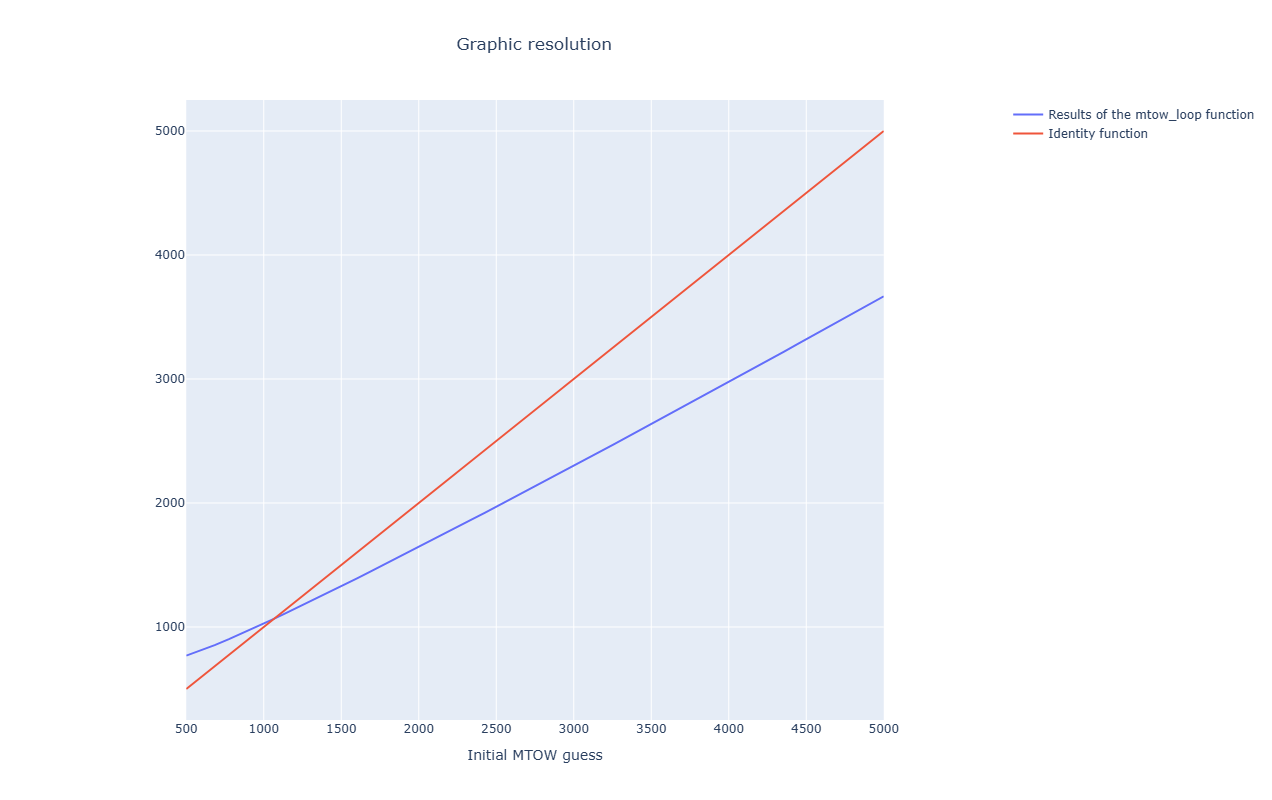

In [6]:
# Let's import the relevant Python library
import plotly.graph_objects as go

# Create two arrays with the initial value and the results
MTOW_initial = np.linspace(500.0, 5000.0)
MTOW_new = np.zeros(len(MTOW_initial))

# Compute the new values
for idx, mtow in enumerate(MTOW_initial):
    MTOW_new[idx] = mtow_loop(
        mtow,
        aspect_ratio,
        wing_loading,
        cruise_altitude,
        cruise_speed,
        mission_range,
        payload,
        tsfc,
    )

# Plot the results
fig = go.Figure()
new_mtow_scatter = go.Scatter(
    x=MTOW_initial,
    y=MTOW_new,
    mode="lines",
    name="Results of the mtow_loop function",
    showlegend=True,
)
fig.add_trace(new_mtow_scatter)
old_mtow_scatter = go.Scatter(
    x=MTOW_initial, y=MTOW_initial, mode="lines", name="Identity function", showlegend=True
)
fig.add_trace(old_mtow_scatter)
fig.layout = go.Layout(
    yaxis=dict(scaleanchor="x", scaleratio=0.8),
    height=800,
    title_text="Graphic resolution",
    title_x=0.42,
)
fig.update_yaxes(constrain="domain")
fig.update_xaxes(constrain="domain", title="Initial MTOW guess")
fig.show()

There is indeed an intersection at around 1050 kg. Let's then continue our computation to find the right solution.

<div class="alert alert-block alert-info">
<b>Remark:</b>

In order to plot the graphs, we used the <a href="https://plotly.com/python/">Plotly</a> package. It allows to zoom on the figure, providing a rather accurate guess on the solution.
    
</div>

<a id='dichotomy'></a>

In [7]:
# Let's start by defining the accuracy with which we want to solve our problem
accuracy = 0.01

# Classic dichotomy algorithm where we narrow the search interval until the bounds are close enough.
while abs(lower_value - upper_value) > accuracy:
    middle_value = (lower_value + upper_value) / 2.0
    middle_value_result = (
        mtow_loop(
            middle_value,
            aspect_ratio,
            wing_loading,
            cruise_altitude,
            cruise_speed,
            mission_range,
            payload,
            tsfc,
        )
        - middle_value
    )

    if middle_value_result * lower_value_result < 0.0:
        upper_value = middle_value
    else:
        lower_value = middle_value

MTOW_result = middle_value
print("The solution MTOW is equal to", np.round(MTOW_result, 1), "kg")

The solution MTOW is equal to 1065.8 kg


As we suspected, the intersection was around 1050 kg. To verify it once more, we can recompute a new **MTOW** using this result and verifiy that we get an output **MTOW** close enough to the input.

In [8]:
MTOW_result_verif = mtow_loop(
    MTOW_result,
    aspect_ratio,
    wing_loading,
    cruise_altitude,
    cruise_speed,
    mission_range,
    payload,
    tsfc,
)
print("MTOW input: ", np.round(MTOW_result, 1), "kg")
print("MTOW output: ", np.round(MTOW_result_verif, 1), "kg")

MTOW input:  1065.8 kg
MTOW output:  1065.8 kg


## Advantages and drawbacks

The advantage of solving the MDA this way is that it is fairly simple to code and without a lot of prior knowledge in Python. Additionnaly, only basic libraries were used (we only used 3: numpy for easier data storage and mathematic operations, plotly for the graph and a subpackage of scipy which contains constants for easier unit conversion).

There are however also a certain number of drawbacks : 
* Using a dichotomy method is a relatively slow way of solving an MDA problem, especially for more complex ones.
* A recurring problem for this method and the method presented in [the next notebook](03_scipy.ipynb) is the units of the data. The functions were written to take only metric units or units derived from the metric system. This forces us to have some inputs written in an unusual way. The range, for instance, is written in meter. The usual way for an aircraft design problem would be to use nautical miles. This forces the user to handle the unit conversion by himself and to manipulate abstract data. It also imposes to be consistent with the units of the data, which is not always the case in the aircraft design formula (an example being the formula we used for the wing mass).
* Another problem that will be illustrated in the next section is the lack of input/output modularity. By default only the new **MTOW** is returned here and we have have no access to intermediate data. This means that we would have to recode a new function if we wanted, let's say, the fuel consumed during the mission. We could alternatively print them. This, however, would not allow us to interact with the data, merely seeing them. We could also write them inside of a separate file but this would add unnecessary complexity. Finally, we could also create a dictionary with all data and their units but the construction would be manual and would need to be changed for each problem based on the models used.

## MDO solving

In this part, we will solve two simple MDO problems, which consists in finding the aspect ratio which respectively gives the lowest MTOW for the given mission and the lowest fuel consumed. In this notebook, the MDO will be "solved" very roughly without using complicated Python library. More accurate results will be obtained in the following notebooks.

### MTOW optimisation

To solve the first point, we will retake the dichotomy methodology (for convenience) and wrap it as a function that finds the **MTOW** for a given set of data. Then, we will vary the input aspect ratio to find the one that gives the best results. Said function, defined in the following cell, could be used to rewrite [this cell](#dichotomy) as:

>print(solve_MTOW(wing_loading, aspect_ratio, cruise_altitude, cruise_speed, mission_range, payload, tsfc))

<a id='solver_function'></a>

In [9]:
def solve_MTOW(
    wing_loading, aspect_ratio, cruise_altitude, cruise_speed, mission_range, payload, tsfc
):
    accuracy = 0.01
    lower_value = 500.0  # Initial lower value for the MTOW, in kg
    upper_value = 5000.0  # Initial upper value for the MTOW, in kg

    lower_value_result = (
        mtow_loop(
            lower_value,
            aspect_ratio,
            wing_loading,
            cruise_altitude,
            cruise_speed,
            mission_range,
            payload,
            tsfc,
        )
        - lower_value
    )

    while abs(lower_value - upper_value) > accuracy:
        middle_value = (lower_value + upper_value) / 2.0
        middle_value_result = (
            mtow_loop(
                middle_value,
                aspect_ratio,
                wing_loading,
                cruise_altitude,
                cruise_speed,
                mission_range,
                payload,
                tsfc,
            )
            - middle_value
        )
        if middle_value_result * lower_value_result < 0.0:
            upper_value = middle_value
        else:
            lower_value = middle_value
            lower_value_result = middle_value_result

    MTOW_result = middle_value

    return MTOW_result

Let's first check that this function gives the same solution with the same inputs.

In [10]:
MTOW_verif = solve_MTOW(
    wing_loading,
    aspect_ratio,
    cruise_altitude,
    cruise_speed,
    mission_range,
    payload,
    tsfc,
)

print("Verification :", np.round(MTOW_verif, 1), "kg")

Verification : 1065.8 kg


We will now try a wide variety of aspect ratio and see which one gives the lowest **MTOW**. This is a very basic and inefficient way of optimizing the aircraft, as we are bound to explore the whole design space, even if the trend seems to suggest that a minimum won't be found here.

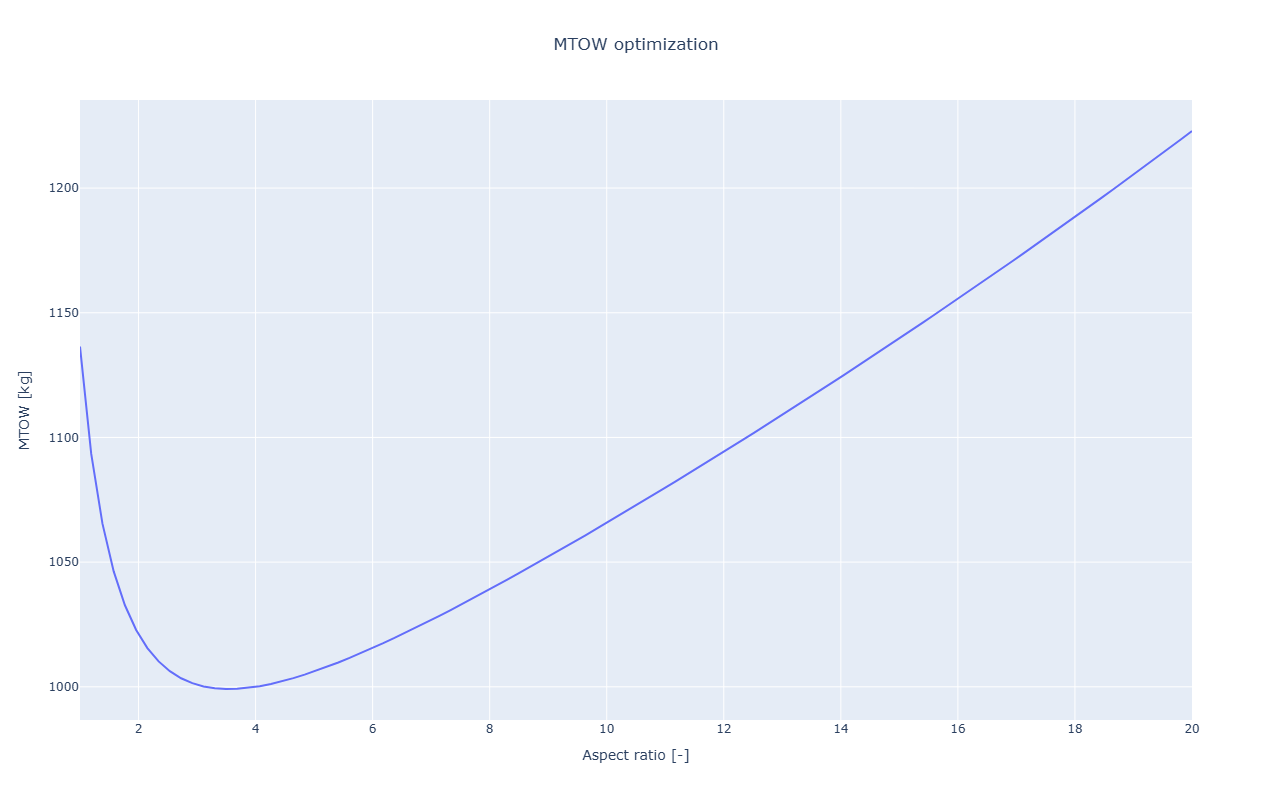

The minimum MTOW is  999.114 kg
The aspect ratio which gives the minimum MTOW is  3.495


In [11]:
AR_array = np.linspace(1.0, 20.0, 100)
MTOW_result = np.zeros_like(AR_array)

for idx, aspect_ratio in enumerate(AR_array):
    MTOW_result[idx] = solve_MTOW(
        wing_loading, aspect_ratio, cruise_altitude, cruise_speed, mission_range, payload, tsfc
    )

# Plot results
fig = go.Figure()
mtow_optim_scatter = go.Scatter(x=AR_array, y=MTOW_result, mode="lines")
fig.add_trace(mtow_optim_scatter)
fig.layout = go.Layout(height=800, title_text="MTOW optimization", title_x=0.5)
fig.update_yaxes(constrain="domain", title="MTOW [kg]")
fig.update_xaxes(constrain="domain", title="Aspect ratio [-]")
fig.show()

min_MTOW_AR = AR_array[np.where(MTOW_result == np.min(MTOW_result))[0]]
print("The minimum MTOW is ", np.round(np.min(MTOW_result), 3), "kg")
print("The aspect ratio which gives the minimum MTOW is ", np.round(min_MTOW_AR[0], 3))

### Fuel consumption optimization

Let's now move on to the search for the aspect ratio that gives the best fuel consumption for the same mission. The issue here is that, in the default delivery of this tutorial and as mentioned before, we neither have access to intermediate computation (we could have used the value of the fuel consumed for the last computation of the **MTOW**) nor do we have a function that computes the fuel weight on its own. 

This means that the user will have to either code its own function, or modify the existing ones. Here, we chose the latter. This issue is easily fixed in FAST-OAD as will be shown later. 

Luckily for us, the fuel is almost accessible as it is an output of a model main function, even if it is not returned by `mtow_loop`. To solve our issue, we only have to declare two outputs : the fuel and the **MTOW**. This is done in a new function, called `mtow_and_fuel_loop`, which can be found in the [mtow_and_fuel_loop.py file](modules/pure_python/mtow_and_fuel_loop.py). This change was made relatively easy by the fact that the fuel was already computed fairly close to the end result, but this may not always be the case.

Like for the `mtow_loop` function, we will define a function that solves the problem and returns the mission fuel that corresponds to the converged aircraft. Indeed, even if we aim at minimizing the fuel consumption, we still have the constraint of having a sized aircraft ! Said function does the same as the one presented [here](#solver_function) with the only difference being that we additionally make the fuel consumed available.

In [12]:
from modules.pure_python.mtow_and_fuel_loop import mtow_and_fuel_loop


def solve_MTOW_and_fuel(
    wing_loading, aspect_ratio, cruise_altitude, cruise_speed, mission_range, payload, tsfc
):
    accuracy = 0.01
    lower_value = 500.0  # Initial lower value for the MTOW, in kg
    upper_value = 5000.0  # Initial upper value for the MTOW, in kg

    lower_value_result_MTOW = (
        mtow_and_fuel_loop(
            lower_value,
            aspect_ratio,
            wing_loading,
            cruise_altitude,
            cruise_speed,
            mission_range,
            payload,
            tsfc,
        )[0]
        - lower_value
    )

    while abs(lower_value - upper_value) > accuracy:
        middle_value = (lower_value + upper_value) / 2.0
        middle_value_result_MTOW, middle_value_result_fuel = mtow_and_fuel_loop(
            middle_value,
            aspect_ratio,
            wing_loading,
            cruise_altitude,
            cruise_speed,
            mission_range,
            payload,
            tsfc,
        )
        middle_value_result_MTOW -= middle_value
        if middle_value_result_MTOW * lower_value_result_MTOW < 0.0:
            upper_value = middle_value
        else:
            lower_value = middle_value
            lower_value_result_MTOW = middle_value_result_MTOW

    MTOW_result = middle_value_result_MTOW
    fuel_result = middle_value_result_fuel

    return MTOW_result, fuel_result

We will now try a variety of aspect ratio and see which one gives the lowest fuel consumption for each converged aircraft.

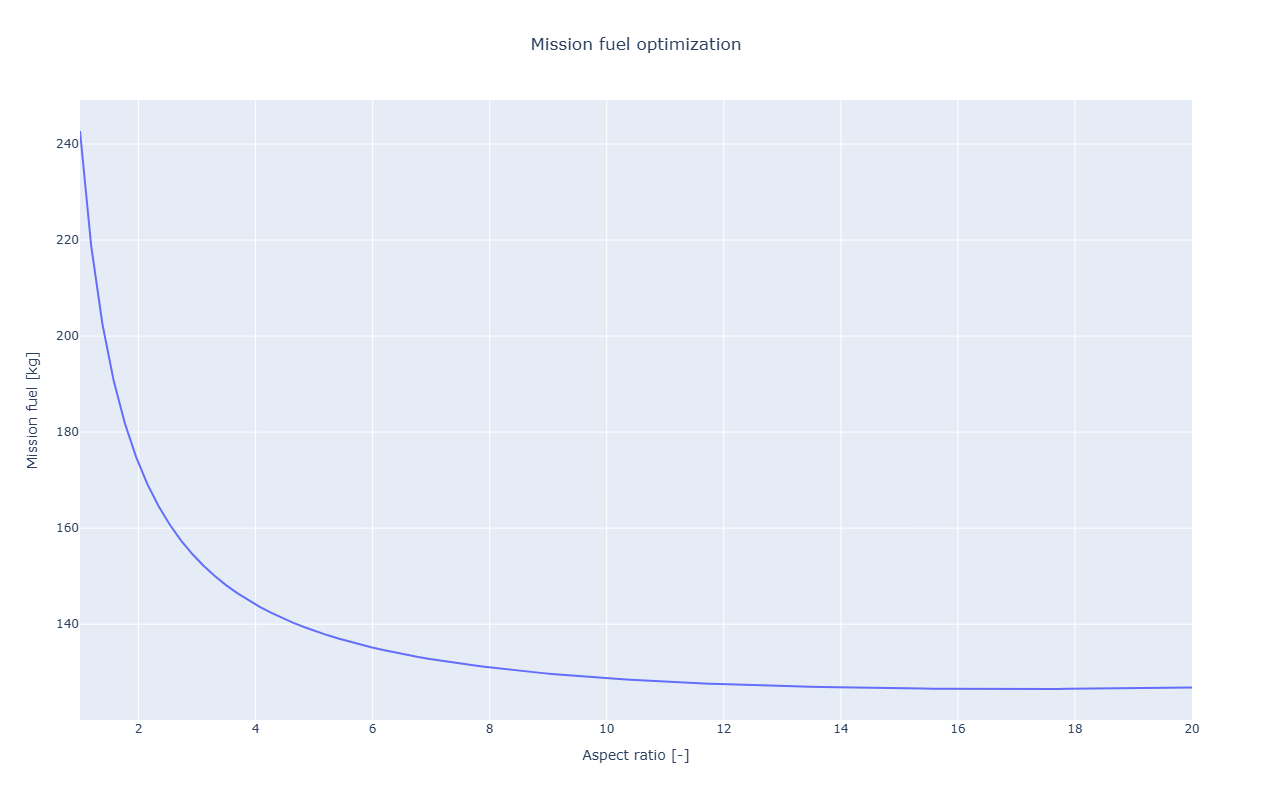

The minimum fuel consumed is  126.5044 kg
The aspect ratio which gives the minimum fuel consumed is  16.9293


In [13]:
fuel_result = np.zeros_like(AR_array)

for idx, aspect_ratio in enumerate(AR_array):
    fuel_result[idx] = solve_MTOW_and_fuel(
        wing_loading, aspect_ratio, cruise_altitude, cruise_speed, mission_range, payload, tsfc
    )[1]

# Plot results
fig = go.Figure()
fuel_optim_scatter = go.Scatter(x=AR_array, y=fuel_result, mode="lines")
fig.add_trace(fuel_optim_scatter)
fig.layout = go.Layout(height=800, title_text="Mission fuel optimization", title_x=0.5)
fig.update_yaxes(constrain="domain", title="Mission fuel [kg]")
fig.update_xaxes(constrain="domain", title="Aspect ratio [-]")
fig.show()

min_fuel_AR = AR_array[np.where(fuel_result == np.min(fuel_result))[0]]
print("The minimum fuel consumed is ", np.round(np.min(fuel_result), 4), "kg")
print("The aspect ratio which gives the minimum fuel consumed is ", np.round(min_fuel_AR[0], 4))

Here, we can see that the aspect ratio which gives the minimum fuel consumed is different from the one which gives the smallest MTOW. 

Even though we successfully managed to conduct our optimization, this example highlights that in order to even slightly modify what we want to compute, and even if the method is already coded, the user has to modify the code and change the implementation of the methods. It could be much simpler if the user could "add the blocks" that he wanted to have for the computation or if he could access intermediate variable at each time of the computation.

This would be especially true for deeper modifications of the code. Let's take, for instance, the addition of the horizontal tailplane sizing along with its impact on mass and aerodynamics. To do so, we would not only need to add the model sub-functions to do the proper computations, but also change the model main functions for the impacted disciplines as well as the program main functions. Not to mention, if we were to remove said new models for whatever reasons, we would have to not only remove the sub-functions but also revert changes to the main model and program functions.

### Optimization with two parameters

Another interesting optimization would be to study the effects of a combined change of two parameters, for instance the cruise speed and the aspect ratio. It is worth mentionning that this study, even if interesting from an optimization point of view, does not makes much sense from an aicraft design point of view. The cruise speed is traditionally a sales argument and is thus usually taken as high as technically possible.

We will now study the effect on the fuel consumption of the two parameters mentionned above. To do so, we will reuse the [`mtow_and_fuel_loop function`](modules/pure_python/mtow_and_fuel_loop.py) which we will run for several combination of cruise speed and aspect ratio. After that, we will be able to find the combination that gives the lowest fuel consumption on the mission.

In [14]:
cruise_speed_array = np.linspace(50.0, 200.0, 100)
fuel_result_2D = np.zeros((len(cruise_speed_array), len(AR_array)))

for idx_aspect_ratio, aspect_ratio in enumerate(AR_array):
    for idx_cruise_speed, cruise_speed in enumerate(cruise_speed_array):
        fuel = solve_MTOW_and_fuel(
            wing_loading, aspect_ratio, cruise_altitude, cruise_speed, mission_range, payload, tsfc
        )[1]
        fuel_result_2D[idx_aspect_ratio, idx_cruise_speed] = fuel

index = np.where(fuel_result_2D == np.amin(fuel_result_2D))
print("The minimum fuel consumed is ", np.round(np.min(fuel_result_2D), 4), "kg")
print("The corresponding aspect ratio is : ", np.round(AR_array[index[0]][0], 4))
print("The corresponding cruise speed is : ", np.round(cruise_speed_array[index[1]][0], 4), "m/s")

The minimum fuel consumed is  119.3731 kg
The corresponding aspect ratio is :  17.8889
The corresponding cruise speed is :  65.1515 m/s


The next bit of code is only there to get a visual of the optimization, it doesn't serve any practical purpose.

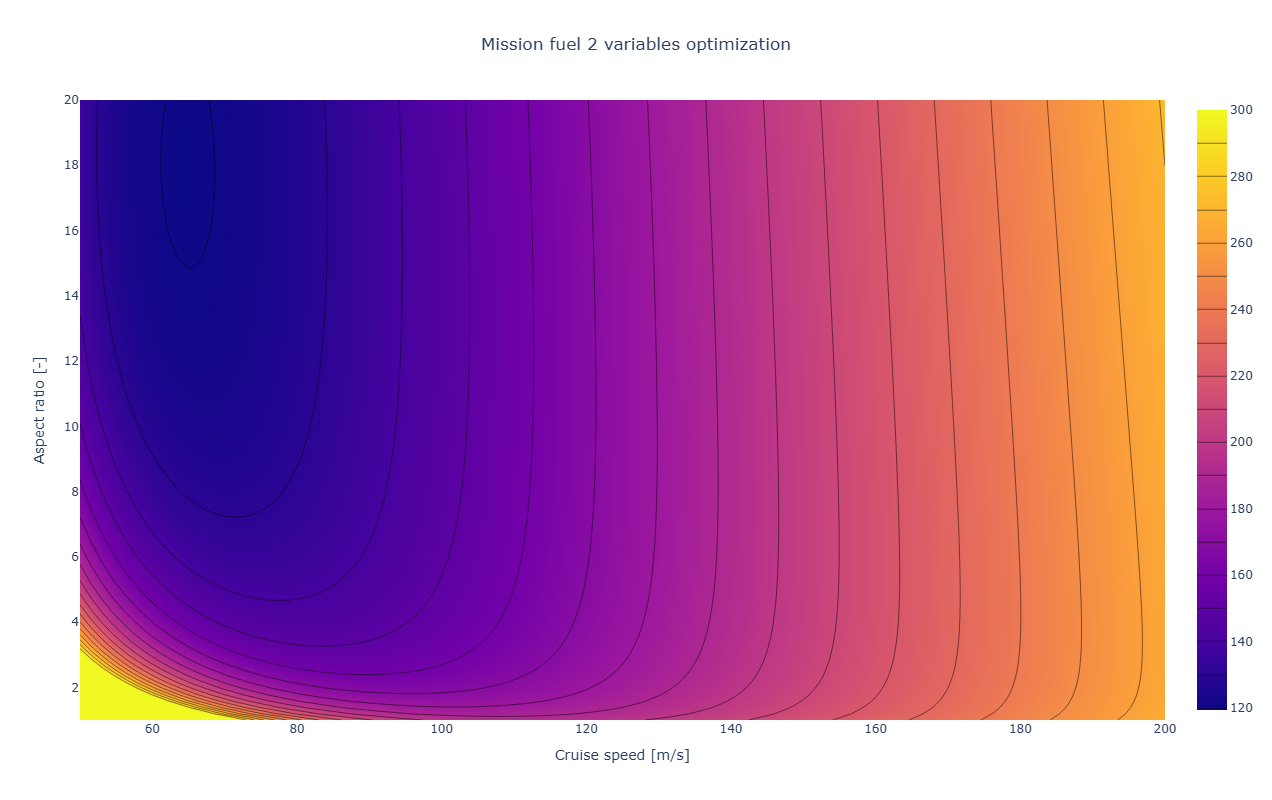

In [15]:
[cruise_speed_array_mesh, AR_array_mesh] = np.meshgrid(cruise_speed_array, AR_array)

# Plot results
fig = go.Figure()
fuel_2D_optim_scatter = go.Contour(
    x=cruise_speed_array,
    y=AR_array,
    z=fuel_result_2D,
    line_smoothing=0.85,
    ncontours=20,
    contours_coloring="heatmap",
    zmax=300,
    zmin=np.min(fuel_result_2D),
)
fig.add_trace(fuel_2D_optim_scatter)
fig.layout = go.Layout(height=800, title_text="Mission fuel 2 variables optimization", title_x=0.5)
fig.update_yaxes(constrain="domain", title="Aspect ratio [-]")
fig.update_xaxes(constrain="domain", title="Cruise speed [m/s]")
fig.show()

## Conclusion 

These few examples showed how we could have coded a very basic multidisciplinary problem if we didn't want to use any "complex" Python package. It also highlighted some of the limits, addressed in FAST-OAD, of coding it this way. These limitations were :
* Changing the way the blocks are organized requires to go deep into the code, even if the basic blocks are already there. This can be off-putting for user that simply seek to use the code and are not destined to modify it.
* Optimization may require way more execution of the code than necessary because of the optimization algorithm.
* We only had a few data in this problem. However, for more complex problem the data management is going to become increasingly harder, with longer function definition, making it more prone to errors.